In [ ]:
# # Copy dataset

# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir /content/data
# !cp -R "/content/drive/MyDrive/Colab Notebooks/skin-cancer/data/train" /content/data
# !cp -R "/content/drive/MyDrive/Colab Notebooks/skin-cancer/data/valid" /content/data

In [ ]:
!mkdir out/

In [ ]:
# Load packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, RandomRotation, RandomAffine
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Training

After performing EDA, we now know more about the dataset and we can use that to guide us in finding a solution for the problem. We want to classify each image into one of these three categories: `melanoma`, `nevus`, and `seborrheic_keratosis`.

In [ ]:
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']
n_classes = len(classes)

The task at hand is a **multi-class classification**. Artificial Neural Networks are inherently adapted to such tasks. More specifically, Convolutional Neural Networks (CNNs) are particularly suited for image processing and computer vision tasks since they automatically perform feature extraction.

## Dataset statistics

In [ ]:
# # Compute dataset statistics for normalization
# transform = Compose([Resize(224), CenterCrop(224), ToTensor()])
# dataset = ImageFolder('data/train', transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, num_workers=0, shuffle=False)

# n_batches = 0
# mean = 0
# squared_sum = 0

# for data, _ in dataloader:
#     mean += torch.mean(data, dim=[0, 2, 3])
#     squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#     n_batches += 1

# mean /= n_batches
# std = (squared_sum / n_batches - mean**2)**.5

# mean = mean.tolist()
# std = std.tolist()

In [ ]:
mean = [0.7116625905036926, 0.584557056427002, 0.5350210666656494]

In [ ]:
std = [0.14735904335975647, 0.16540414094924927, 0.18036234378814697]

## Transfer Learning

Instead of designing the network architecture ourselves, we can make use of pretrained models that come with deep learning frameworks.

We will be using the [VGG network](https://arxiv.org/abs/1409.1556). The first layers serve as a feature extractor and are made up of convolution and pooling layers. The feature map is then passed on to a few fully-connected layers that can be considered as a classifier.

In [ ]:
model = models.vgg16(pretrained=True, progress=False)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We have to change the last layer so that it has as many nodes as the number of classes. We don't freeze the weights since we want to retrain the entire network.

In [ ]:
# Changing last layer

n_before_last = model.classifier[6].in_features
model.classifier[6] = nn.Linear(n_before_last, n_classes)

## Preparing the data

The VGG network accepts 224x224 colored images.


In [ ]:
# Load the data

transform_train = Compose([Resize(224), CenterCrop(224), ToTensor(),  # Preprocess the images and convert them to tensors
                           RandomRotation(10), RandomAffine(degrees=0, scale=(0.98, 1.2)),  # Data Augmentation
                           Normalize(mean=mean, std=std)  # Normalization
                           ])


transform_valid = Compose([Resize(224), CenterCrop(224), ToTensor(),  # Preprocess the images and convert them to tensors
                           Normalize(mean=mean, std=std)  # Normalization
                           ])

train_data = ImageFolder('data/train', transform=transform_train)
valid_data = ImageFolder('data/valid', transform=transform_valid)

# Use DataLoader to iterate over the dataset using batches

num_workers = 0
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

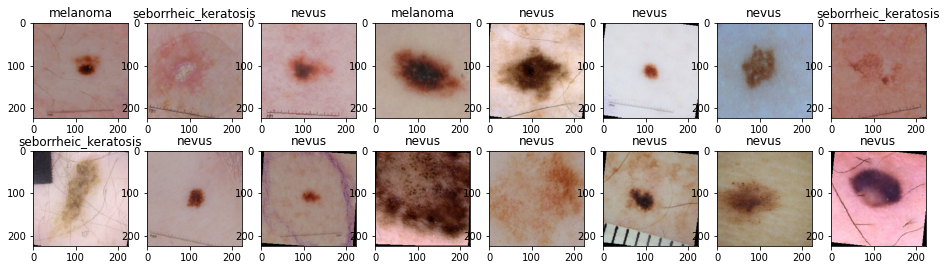

In [ ]:
# Print out some samples

images, labels = next(iter(train_loader))

plt.figure(figsize=(16, 9))

for i in range(batch_size//2):
    plt.subplot(4, batch_size//4, i+1)
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Switch from CHW to HWC
    plt.imshow(np.clip(std * img + mean, 0, 1))  # Undo normalization
    plt.title(classes[labels[i]])

## Training Loop

Now that we have taken care of the architecture of our model, we can move onto training it. We want to train our model on a GPU to save time. We will also need to define a `loss function` and an `optimizer`.

In [ ]:
# Check if a GPU is available

gpu_available = torch.cuda.is_available()

if gpu_available:
    model.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # We retrain the entire model
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)  # Learning rate scheduler

In [ ]:
# Define training parameters

n_epochs = 20
print_every_n_batches = 30

# Keep track of the loss and accuracy

train_losses = []
valid_losses = []
valid_accuracy = []
overall_accuracy = []

max_valid_acc = 0

# Training loop

for epoch in range(1, n_epochs+1):
    
    # Training

    model.train()

    train_loss_n_batches  = 0
    train_loss = 0
    
    for batch_id, (data, target) in enumerate(train_loader):

        if gpu_available:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        
        # Feed forward
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)

        train_loss_n_batches += loss.item()
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        if batch_id % print_every_n_batches == print_every_n_batches-1:
            msg = 'Epoch {}, Batch {} Training Loss: {:.8f}'
            print(msg.format(epoch, batch_id + 1, train_loss_n_batches / print_every_n_batches))
            train_loss_n_batches  = 0  

            
    # Evaluation

    model.eval()

    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]     
    valid_loss = 0
    valid_acc = [0] * n_classes
    overall_acc = []

    with torch.no_grad():
        for data, target in valid_loader:

            if gpu_available:
                data, target = data.cuda(), target.cuda()

            output = model(data)
           
            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)

            prob = F.softmax(output, dim=1)

            _, pred = torch.max(prob, dim=1)    
            
            correct = (pred == target).type(torch.FloatTensor)

            overall_acc.append(torch.mean(correct).item())

            for i in range(len(target)):
                label = target.cpu().numpy()[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    for i in range(n_classes):
        if class_total[i] > 0:
            valid_acc[i] = 100 * class_correct[i] / class_total[i]
            print('Validation Accuracy of {}: {:.8f}'.format(classes[i], valid_acc[i]))

    overall_acc = sum(overall_acc) / len(overall_acc) * 100
    print('>>> Overall Validation Accuracy: {:.8f}'.format(overall_acc))

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracy.append(valid_acc)
    overall_accuracy.append(overall_acc)

    scheduler.step()

    if overall_acc > max_valid_acc:
        max_valid_acc = overall_acc
        if (epoch>=5):
            print('Best validation accuracy yet! Saving model...')
            torch.save(model, 'out/model-{}epochs.pth'.format(epoch))


Epoch 1, Batch 30 Training Loss: 0.92824998
Epoch 1, Batch 60 Training Loss: 0.77130364
Validation Accuracy of melanoma: 0.00000000
Validation Accuracy of nevus: 100.00000000
Validation Accuracy of seborrheic_keratosis: 0.00000000
>>> Overall Validation Accuracy: 48.75000000
Epoch 2, Batch 30 Training Loss: 0.74769030
Epoch 2, Batch 60 Training Loss: 0.67409120
Validation Accuracy of melanoma: 10.00000000
Validation Accuracy of nevus: 94.87179487
Validation Accuracy of seborrheic_keratosis: 40.47619048
>>> Overall Validation Accuracy: 61.30681813
Epoch 3, Batch 30 Training Loss: 0.65653100
Epoch 3, Batch 60 Training Loss: 0.62099806
Validation Accuracy of melanoma: 13.33333333
Validation Accuracy of nevus: 92.30769231
Validation Accuracy of seborrheic_keratosis: 47.61904762
>>> Overall Validation Accuracy: 63.12500000
Epoch 4, Batch 30 Training Loss: 0.57537156
Epoch 4, Batch 60 Training Loss: 0.60447898
Validation Accuracy of melanoma: 16.66666667
Validation Accuracy of nevus: 97.4358

In [ ]:
valid_accuracy = np.transpose(valid_accuracy) 

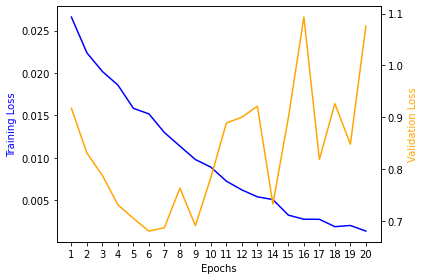

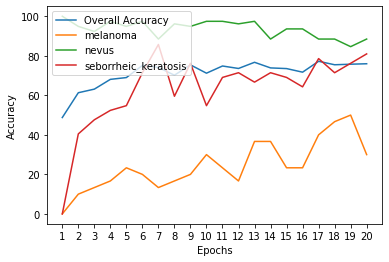

In [ ]:
# Plot training curves
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(range(1, n_epochs+1), train_losses, color='blue')
ax1.set_xlabel('Epochs')
ax1.set_xticks(range(1, n_epochs+1))
ax1.set_ylabel('Training Loss', color='blue')
ax2.plot(range(1, n_epochs+1), valid_losses, color='orange')
ax2.set_ylabel('Validation Loss', color='orange')

fig.tight_layout() 
plt.show()

# Plot accuracy

plt.plot(range(1, n_epochs+1), overall_accuracy, label='Overall Accuracy')
for i in range(n_classes):
    plt.plot(range(1, n_epochs+1), valid_accuracy[i], label=classes[i])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.xticks(range(1, n_epochs+1))
plt.show()

In [ ]:
# Save the trained model
torch.save(model, 'out/model-{}epochs.pth'.format(n_epochs))

> We decide to save the model with the highest overall accuracy during validation (77% obtained after 17 epochs) and use it for further inference. We notice that the model starts overfitting at Epoch # 10 since the validation loss starts increasing significantly.